# FINM 35910 - Applied Algo Trading
## Homework 3

In [343]:
import pandas as pd
import numpy as np
import requests as re
from sklearn.linear_model import LinearRegression
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
data = pd.read_excel('./Data/BTC-USD_ETH-USD_Combined_Data.xlsx').set_index('Date')

In [79]:
px.line(data, x=data.index, y='BTC-USD_Close', title='BTC-USD Close Price')

In [ ]:
def strategy(data, sma_list, fund_list):
    df = data.copy()
    for fund in fund_list:
        for interval in sma_list:
            df[fund + "_" + str(interval)] = df[fund+"_Close"].ewm(span=int(interval), adjust=False).mean()
            df[fund + "-" + fund + "_" + str(interval)] = df[fund+"_Close"] - df[fund + "_" + str(interval)]
            df[fund + "_" + str(interval) + "_Signal"] = np.where(df[fund+"_Close"] > df[fund + "_" + str(interval)], 1, 0)
            df[fund + "_" + str(interval) + "_Signal_Change"] = df[fund + "_" + str(interval) + "_Signal"].diff()
            
            # order generation triggered by signal change
            col = fund + "_" + str(interval) + "_Signal_Change"
            conditions = [df[col]==1, df[col]==0, df[col]==-1]
            choices = [1,0,-1]

            df[fund + "_" + str(interval) + "_Action"] = np.select(conditions, choices, default=0)
            
    return df

In [394]:
sma_list = [str(i) for i in range(10, 91, 10)]
sma_list = ['20']
fund_list = ['BTC-USD']

df = strategy(data.loc[data.index>'2019-12-31'], sma_list, fund_list)

print(df['BTC-USD_20_Action'].value_counts())

df.groupby(pd.to_datetime(df.index.date).year)['BTC-USD_20_Action'].value_counts()

BTC-USD_20_Action
 0    1575
 1     102
-1     101
Name: count, dtype: int64


      BTC-USD_20_Action
2020   0                   311
       1                    28
      -1                    27
2021   0                   332
      -1                    17
       1                    16
2022   0                   325
      -1                    20
       1                    20
2023   0                   327
      -1                    19
       1                    19
2024   0                   280
       1                    19
      -1                    18
Name: count, dtype: int64

In [ ]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils import finm_backtester as fb

sim_df = fb.BacktestSim(df['BTC-USD_Close'], df['BTC-USD_20_Action'], initial_cash=100_000, transaction_cost=0.001, slippage=0.0).run()

Buying 13.0 shares at price 7334.45
Selling 13.0 shares at price 8326.81
Buying 13.0 shares at price 8595.0
Selling 13.0 shares at price 9700.0
Buying 12.0 shares at price 10188.04
Selling 12.0 shares at price 9600.08
Buying 11.0 shares at price 9965.01
Selling 11.0 shares at price 9660.0
Buying 12.0 shares at price 9158.51
Selling 12.0 shares at price 8901.37
Buying 16.0 shares at price 6766.64
Selling 16.0 shares at price 6372.36
Buying 15.0 shares at price 6666.11
Selling 15.0 shares at price 6624.12
Buying 14.0 shares at price 7112.64
Selling 14.0 shares at price 6838.19
Buying 14.0 shares at price 7136.84
Selling 14.0 shares at price 8572.4
Buying 13.0 shares at price 8821.42
Selling 13.0 shares at price 9061.96
Buying 13.0 shares at price 9168.84
Selling 13.0 shares at price 8715.73
Buying 12.0 shares at price 9208.53
Selling 12.0 shares at price 9268.16
Buying 12.0 shares at price 9526.25
Selling 12.0 shares at price 9457.51
Buying 12.0 shares at price 9690.74
Selling 12.0 share

In [426]:
sim.portfolio.head()

,action,positions,cash,transaction_fees,position_values,portfolio_values,cumulative_pnl
date,,,,,,,
2020-01-01,HOLD,0.0,100000.00000,0.00000,0.00,100000.00000,0.0
2020-01-02,HOLD,0.0,100000.00000,0.00000,0.00,100000.00000,0.0
2020-01-03,BUY,13.0,4556.80215,95.34785,95347.85,99904.65215,0.0
2020-01-04,HOLD,13.0,4556.80215,95.34785,95532.19,100088.99215,0.0
2020-01-05,HOLD,13.0,4556.80215,95.34785,95620.20,100177.00215,0.0


In [427]:
sim.calculate_metrics(adj=252)

,annualized_mean,annualized_std,sharpe_ratio,sortino_ratio,win_rate,skewness,excess_kurtosis,var_95,cvar_95,min,max,tracking_error,information_ratio,treynor_ratio,jensens_alpha,max_drawdown,peak,bottom,recovery_date
returns,0.321929,0.354591,0.907889,271.538502,0.14,0.627419,7.941629,-0.032344,-0.052508,-0.125782,0.182728,0.401638,0.796521,0.730667,0.320952,-0.547909,2021-10-20,2023-01-05,2024-02-28


In [428]:
sim.calculate_metrics(adj=252, benchmark=True)

,annualized_mean,annualized_std,sharpe_ratio,sortino_ratio,win_rate,skewness,excess_kurtosis,var_95,cvar_95,min,max,tracking_error,information_ratio,treynor_ratio,jensens_alpha,max_drawdown,peak,bottom,recovery_date
returns,0.50798,0.545876,0.930579,313.355311,0.513787,-0.573476,11.813301,-0.050785,-0.077189,-0.388124,0.194916,0.0,inf,0.507822,0.505964,-0.766706,2021-11-08,2022-11-21,2024-03-04


<Axes: xlabel='Date'>

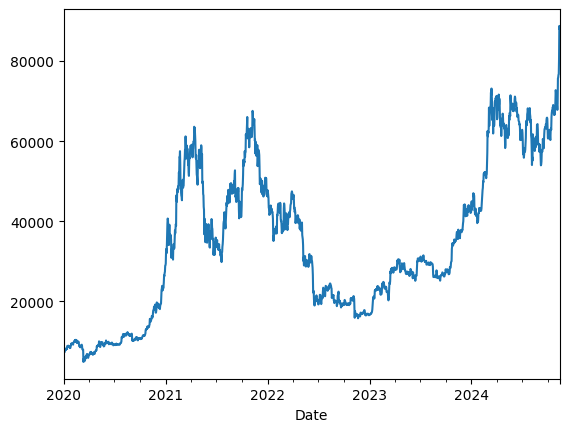

In [414]:
sim.close_price.plot()

<Axes: xlabel='date'>

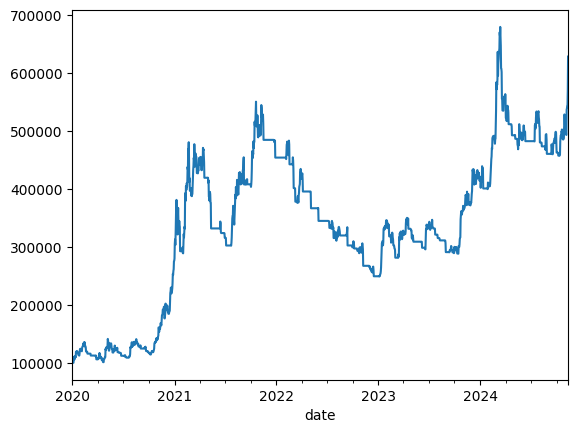

In [429]:
sim.portfolio.portfolio_values.plot()

<Axes: xlabel='date'>

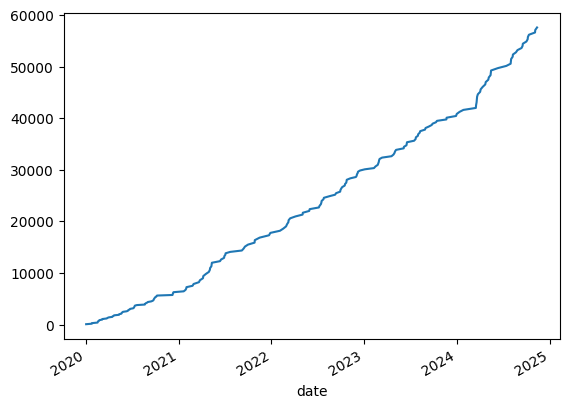

In [431]:
sim.trades.transaction_cost.cumsum().plot()

<Axes: xlabel='date'>

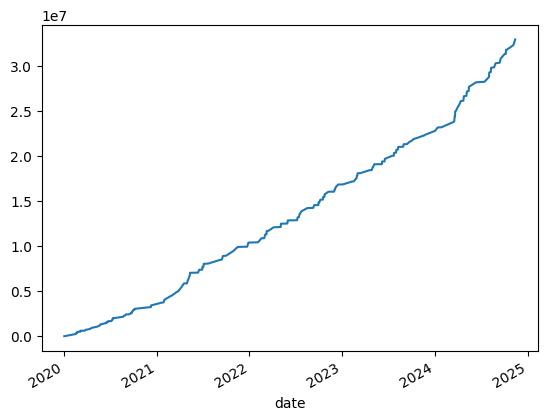

In [432]:
sim.trades.cash.cumsum().plot()